# Deep Dive 1: Time Between Funding Rounds

**Question**: Does the timing between funding rounds affect startup outcomes? Is NL different?

**Key metrics**:
- Time from founding → first funding
- Time from Seed → Series A
- Time from Series A → Series B
- Funding velocity (rounds per year)

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Colors
COLORS = {
    'nl': '#D55E00', 'usa': '#0072B2', 'israel': '#009E73',
    'uk': '#56B4E9', 'germany': '#E69F00', 'france': '#CC79A7',
    'gray': '#999999', 'success': '#009E73', 'failure': '#D55E00'
}

def tufte_style(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#666666')
    ax.spines['bottom'].set_color('#666666')
    ax.tick_params(colors='#666666')
    ax.grid(False)
    return ax

os.makedirs('figures/deep_dive_1', exist_ok=True)

# Load data
df = pd.read_csv('/Users/coendewith/techleap/investments_VC.csv', encoding='latin-1')
df.columns = df.columns.str.strip()

# Clean
df['country_code'] = df['country_code'].str.strip()
df['founded_at'] = pd.to_datetime(df['founded_at'], errors='coerce')
df['first_funding_at'] = pd.to_datetime(df['first_funding_at'], errors='coerce')
df['last_funding_at'] = pd.to_datetime(df['last_funding_at'], errors='coerce')

# Filter 2005-2014
df = df[df['first_funding_at'].notna()]
df = df[(df['first_funding_at'].dt.year >= 2005) & (df['first_funding_at'].dt.year <= 2014)]

# Funding columns
for col in ['seed', 'round_A', 'round_B', 'round_C', 'funding_rounds']:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

df['had_seed'] = df['seed'] > 0
df['had_series_a'] = df['round_A'] > 0
df['had_series_b'] = df['round_B'] > 0
df['exited'] = df['status'].isin(['acquired', 'ipo'])
df['failed'] = df['status'] == 'closed'

COUNTRIES = {'NLD': 'Netherlands', 'USA': 'USA', 'ISR': 'Israel', 
             'GBR': 'UK', 'DEU': 'Germany', 'FRA': 'France'}

benchmark = df[df['country_code'].isin(COUNTRIES.keys())].copy()
benchmark['country'] = benchmark['country_code'].map(COUNTRIES)

print(f"Companies: {len(benchmark):,}")

Companies: 33,364


---
## 1.1 Time from Founding to First Funding

How long do companies wait before raising their first round?

In [2]:
# Calculate time to first funding
benchmark['years_to_first'] = (benchmark['first_funding_at'] - benchmark['founded_at']).dt.days / 365.25
valid = benchmark[(benchmark['years_to_first'] >= 0) & (benchmark['years_to_first'] <= 15)]

# Summary by country
timing_summary = valid.groupby('country')['years_to_first'].agg(['median', 'mean', 'std', 'count'])
timing_summary = timing_summary.sort_values('median')
print("TIME TO FIRST FUNDING (years)")
print(timing_summary.round(2))

TIME TO FIRST FUNDING (years)
             median  mean   std  count
country                               
Germany        1.19  2.24  2.71    639
Netherlands    1.38  2.57  2.93    213
USA            1.70  2.96  3.27  20438
UK             1.81  2.96  3.18   1709
Israel         1.85  2.93  3.09    539
France         2.15  3.12  3.06    603


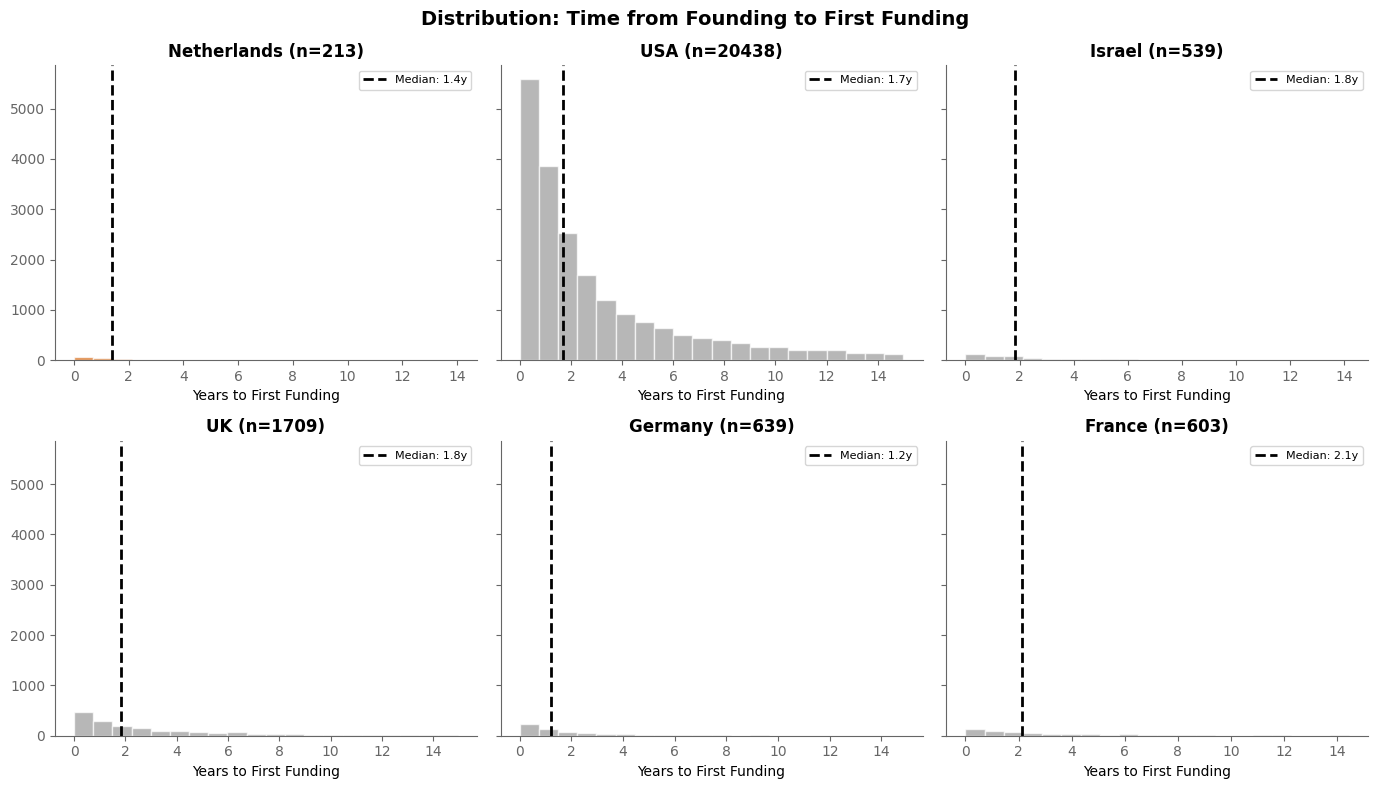

In [3]:
# Visualization: Distribution by country
fig, axes = plt.subplots(2, 3, figsize=(14, 8), sharey=True)
axes = axes.flatten()

for i, (code, name) in enumerate(COUNTRIES.items()):
    ax = tufte_style(axes[i])
    data = valid[valid['country_code'] == code]['years_to_first']
    color = COLORS['nl'] if code == 'NLD' else COLORS['gray']
    
    ax.hist(data, bins=20, color=color, alpha=0.7, edgecolor='white')
    ax.axvline(data.median(), color='black', linestyle='--', linewidth=2, label=f'Median: {data.median():.1f}y')
    ax.set_title(f'{name} (n={len(data)})', fontweight='bold')
    ax.set_xlabel('Years to First Funding')
    ax.legend(loc='upper right', fontsize=8)

plt.suptitle('Distribution: Time from Founding to First Funding', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('figures/deep_dive_1/time_to_first_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

In [4]:
# Key finding: Does timing to first funding affect outcomes?
def outcome_by_first_timing(data, timing_bucket):
    if timing_bucket == 'fast':
        subset = data[data['years_to_first'] < 1]
    elif timing_bucket == 'normal':
        subset = data[(data['years_to_first'] >= 1) & (data['years_to_first'] < 3)]
    elif timing_bucket == 'slow':
        subset = data[(data['years_to_first'] >= 3) & (data['years_to_first'] < 5)]
    else:  # very slow
        subset = data[data['years_to_first'] >= 5]
    
    if len(subset) < 5:
        return np.nan, np.nan, 0
    return subset['exited'].mean() * 100, subset['failed'].mean() * 100, len(subset)

buckets = ['fast', 'normal', 'slow', 'very_slow']
bucket_labels = ['<1 year', '1-3 years', '3-5 years', '5+ years']

results = []
for code, name in COUNTRIES.items():
    data = valid[valid['country_code'] == code]
    for bucket, label in zip(buckets, bucket_labels):
        exit_rate, fail_rate, n = outcome_by_first_timing(data, bucket)
        results.append({'country': name, 'timing': label, 'exit_rate': exit_rate, 'fail_rate': fail_rate, 'n': n})

results_df = pd.DataFrame(results)
print("\nEXIT RATE BY TIME TO FIRST FUNDING:")
pivot = results_df.pivot(index='timing', columns='country', values='exit_rate')
print(pivot.round(1))


EXIT RATE BY TIME TO FIRST FUNDING:
country    France  Germany  Israel  Netherlands   UK   USA
timing                                                    
1-3 years     3.8      5.9    10.0          1.7  4.2   7.5
3-5 years     8.3     10.1    10.7          0.0  4.5  10.1
5+ years      9.0      5.9    10.3         12.8  9.8  11.6
<1 year       2.8      6.7     6.7          2.3  3.7   8.5


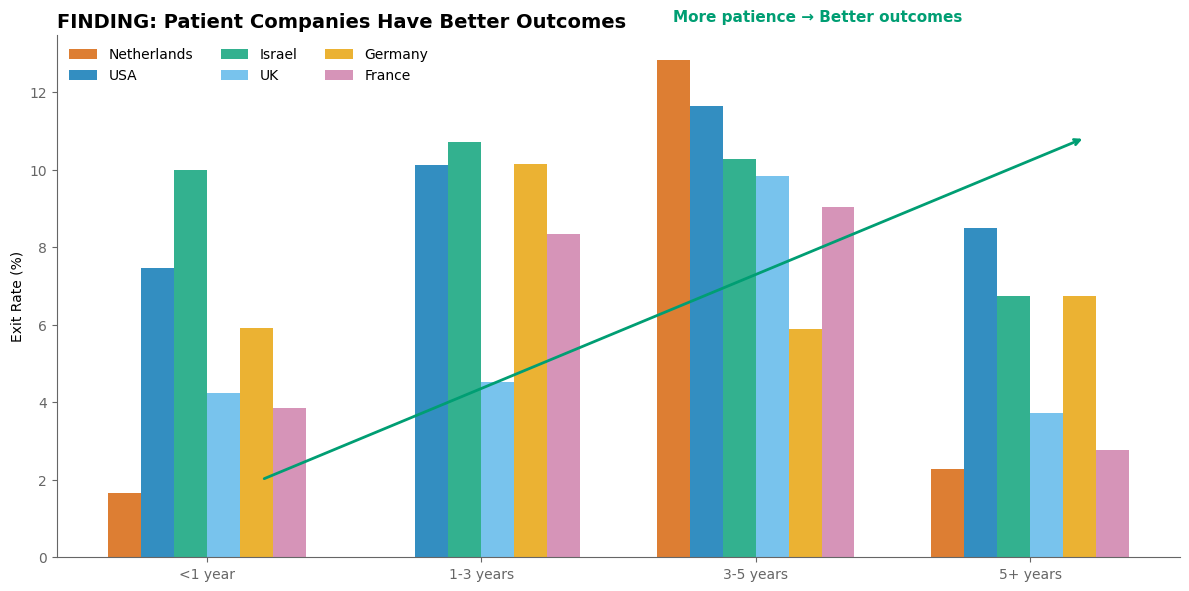

In [5]:
# Visualization: Timing vs Outcomes
fig, ax = plt.subplots(figsize=(12, 6))
tufte_style(ax)

x = np.arange(len(bucket_labels))
width = 0.12

country_colors = {'Netherlands': COLORS['nl'], 'USA': COLORS['usa'], 'Israel': COLORS['israel'],
                  'UK': COLORS['uk'], 'Germany': COLORS['germany'], 'France': COLORS['france']}

for i, country in enumerate(COUNTRIES.values()):
    rates = pivot[country].values
    color = country_colors[country]
    bars = ax.bar(x + i*width, rates, width, label=country, color=color, alpha=0.8)

ax.set_xticks(x + width * 2.5)
ax.set_xticklabels(bucket_labels)
ax.set_ylabel('Exit Rate (%)')
ax.set_title('FINDING: Patient Companies Have Better Outcomes', fontsize=14, fontweight='bold', loc='left')
ax.legend(loc='upper left', ncol=3, frameon=False)

# Add trend arrow
ax.annotate('', xy=(3.5, pivot.max().max() - 2), xytext=(0.5, pivot.min().min() + 2),
            arrowprops=dict(arrowstyle='->', color=COLORS['success'], lw=2))
ax.text(2, pivot.max().max() + 1, 'More patience → Better outcomes', 
        fontsize=11, color=COLORS['success'], fontweight='bold')

plt.tight_layout()
plt.savefig('figures/deep_dive_1/timing_vs_outcomes.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 1.2 Funding Duration (First to Last Funding)

How long are companies actively raising?

In [6]:
# Calculate funding duration
benchmark['funding_duration_years'] = (benchmark['last_funding_at'] - benchmark['first_funding_at']).dt.days / 365.25
multi_round = benchmark[(benchmark['funding_rounds'] > 1) & (benchmark['funding_duration_years'] >= 0)]

# Summary
duration_summary = multi_round.groupby('country').agg({
    'funding_duration_years': ['median', 'mean'],
    'funding_rounds': 'mean',
    'country': 'count'
}).round(2)
duration_summary.columns = ['median_duration', 'mean_duration', 'avg_rounds', 'n']
duration_summary = duration_summary.sort_values('median_duration', ascending=False)
print("FUNDING DURATION (multi-round companies only)")
print(duration_summary)

FUNDING DURATION (multi-round companies only)
             median_duration  mean_duration  avg_rounds      n
country                                                       
Israel                  2.03           2.46        2.72    239
USA                     1.95           2.43        3.11  11427
France                  1.92           2.35        2.37    241
UK                      1.73           2.17        2.71    780
Netherlands             1.71           2.11        2.59     88
Germany                 1.45           2.08        2.58    299


In [7]:
# Calculate average time between rounds
multi_round = multi_round.copy()
multi_round['avg_time_between_rounds'] = multi_round['funding_duration_years'] / (multi_round['funding_rounds'] - 1)

time_between = multi_round.groupby('country')['avg_time_between_rounds'].agg(['median', 'mean', 'count'])
time_between = time_between.sort_values('median')
print("\nAVERAGE TIME BETWEEN ROUNDS (years)")
print(time_between.round(2))


AVERAGE TIME BETWEEN ROUNDS (years)
             median  mean  count
country                         
USA            1.05  1.28  11427
Germany        1.10  1.47    299
UK             1.11  1.39    780
Netherlands    1.20  1.43     88
Israel         1.37  1.58    239
France         1.52  1.77    241


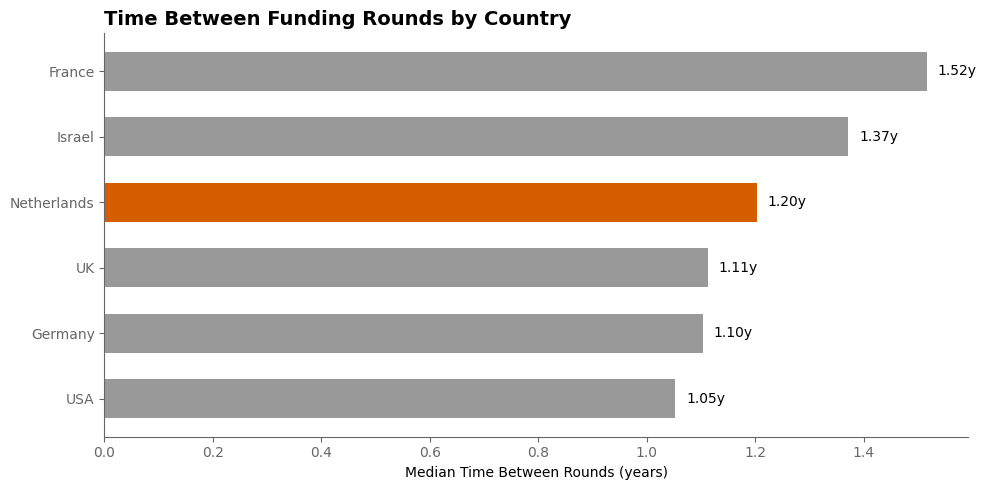

In [8]:
# Visualization: Time between rounds comparison
fig, ax = plt.subplots(figsize=(10, 5))
tufte_style(ax)

countries = time_between.index.tolist()
medians = time_between['median'].values
colors = [COLORS['nl'] if c == 'Netherlands' else COLORS['gray'] for c in countries]

bars = ax.barh(countries, medians, color=colors, height=0.6)
for bar, val in zip(bars, medians):
    ax.text(val + 0.02, bar.get_y() + bar.get_height()/2, f'{val:.2f}y', va='center')

ax.set_xlabel('Median Time Between Rounds (years)')
ax.set_title('Time Between Funding Rounds by Country', fontsize=14, fontweight='bold', loc='left')

plt.tight_layout()
plt.savefig('figures/deep_dive_1/time_between_rounds.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 1.3 Funding Velocity

Rounds per year — does faster = better?

In [9]:
# Calculate funding velocity (rounds per year of funding activity)
multi_round = multi_round.copy()
multi_round['funding_velocity'] = multi_round['funding_rounds'] / multi_round['funding_duration_years'].replace(0, np.nan)
multi_round = multi_round[multi_round['funding_velocity'].notna() & (multi_round['funding_velocity'] < 10)]  # Remove outliers

# Velocity vs outcomes
def velocity_outcome(data, velocity_range):
    subset = data[(data['funding_velocity'] >= velocity_range[0]) & (data['funding_velocity'] < velocity_range[1])]
    if len(subset) < 10:
        return np.nan, 0
    return subset['exited'].mean() * 100, len(subset)

velocity_ranges = [(0, 0.5), (0.5, 1), (1, 2), (2, 10)]
velocity_labels = ['<0.5 r/y\n(Very slow)', '0.5-1 r/y\n(Slow)', '1-2 r/y\n(Normal)', '2+ r/y\n(Fast)']

vel_results = []
for code, name in COUNTRIES.items():
    data = multi_round[multi_round['country_code'] == code]
    for vr, label in zip(velocity_ranges, velocity_labels):
        rate, n = velocity_outcome(data, vr)
        vel_results.append({'country': name, 'velocity': label, 'exit_rate': rate, 'n': n})

vel_df = pd.DataFrame(vel_results)
vel_pivot = vel_df.pivot(index='velocity', columns='country', values='exit_rate')
print("EXIT RATE BY FUNDING VELOCITY:")
print(vel_pivot.round(1))

EXIT RATE BY FUNDING VELOCITY:
country                France  Germany  Israel  Netherlands   UK   USA
velocity                                                              
0.5-1 r/y\n(Slow)         7.7     10.9    11.8         13.0  8.2  12.9
1-2 r/y\n(Normal)         7.2     12.4    13.1          6.2  8.2  13.8
2+ r/y\n(Fast)            4.0      8.3    10.7          7.4  5.0   9.6
<0.5 r/y\n(Very slow)    10.0      4.5     NaN          NaN  5.9  10.6


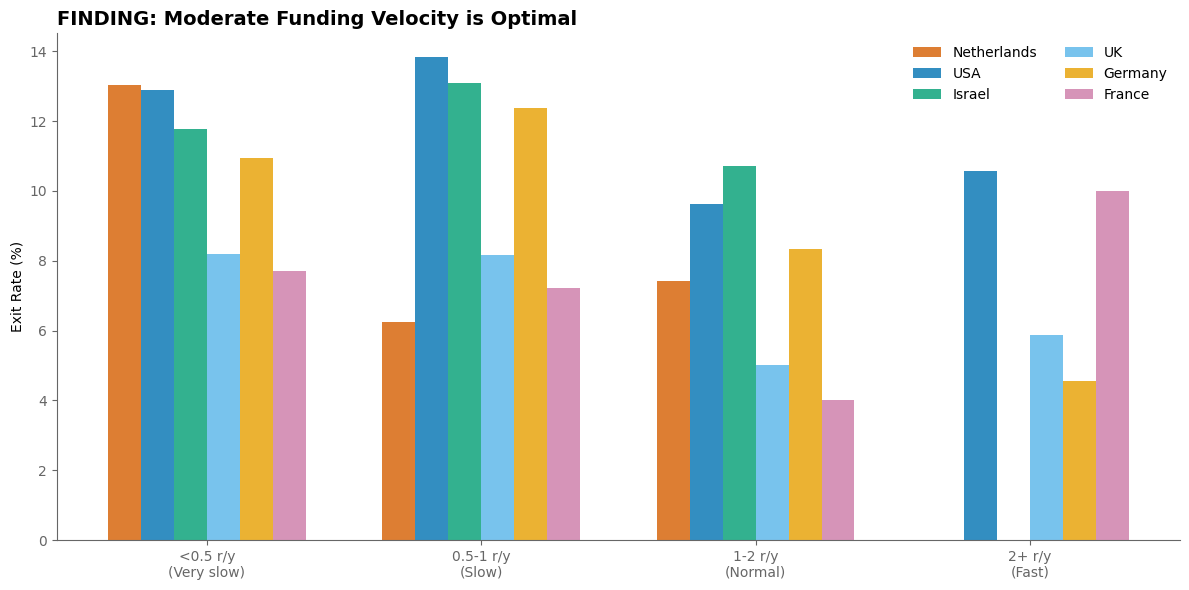

In [10]:
# Visualization: Velocity vs Outcomes
fig, ax = plt.subplots(figsize=(12, 6))
tufte_style(ax)

x = np.arange(len(velocity_labels))
width = 0.12

for i, country in enumerate(COUNTRIES.values()):
    if country in vel_pivot.columns:
        rates = vel_pivot[country].values
        color = country_colors[country]
        ax.bar(x + i*width, rates, width, label=country, color=color, alpha=0.8)

ax.set_xticks(x + width * 2.5)
ax.set_xticklabels(velocity_labels)
ax.set_ylabel('Exit Rate (%)')
ax.set_title('FINDING: Moderate Funding Velocity is Optimal', fontsize=14, fontweight='bold', loc='left')
ax.legend(loc='upper right', ncol=2, frameon=False)

plt.tight_layout()
plt.savefig('figures/deep_dive_1/velocity_vs_outcomes.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 1.4 NL-Specific Timing Analysis

How does Dutch timing differ, and what's the impact?

In [11]:
# NL vs benchmark comparison
nl = valid[valid['country_code'] == 'NLD']
others = valid[valid['country_code'] != 'NLD']

print("NETHERLANDS vs OTHERS: Timing Comparison")
print("="*50)
print(f"\nTime to first funding:")
print(f"  NL median:     {nl['years_to_first'].median():.2f} years")
print(f"  Others median: {others['years_to_first'].median():.2f} years")

nl_multi = multi_round[multi_round['country_code'] == 'NLD']
others_multi = multi_round[multi_round['country_code'] != 'NLD']

print(f"\nTime between rounds (multi-round companies):")
print(f"  NL median:     {nl_multi['avg_time_between_rounds'].median():.2f} years")
print(f"  Others median: {others_multi['avg_time_between_rounds'].median():.2f} years")

print(f"\nFunding velocity:")
print(f"  NL median:     {nl_multi['funding_velocity'].median():.2f} rounds/year")
print(f"  Others median: {others_multi['funding_velocity'].median():.2f} rounds/year")

NETHERLANDS vs OTHERS: Timing Comparison

Time to first funding:
  NL median:     1.38 years
  Others median: 1.71 years

Time between rounds (multi-round companies):
  NL median:     1.29 years
  Others median: 1.11 years

Funding velocity:
  NL median:     1.38 rounds/year
  Others median: 1.42 rounds/year


In [12]:
# Within NL: Does timing predict success?
nl_full = benchmark[benchmark['country_code'] == 'NLD'].copy()
nl_full['years_to_first'] = (nl_full['first_funding_at'] - nl_full['founded_at']).dt.days / 365.25
nl_valid = nl_full[(nl_full['years_to_first'] >= 0) & (nl_full['years_to_first'] <= 15)]

# Bucket NL companies
nl_valid = nl_valid.copy()
nl_valid['timing_bucket'] = pd.cut(nl_valid['years_to_first'], 
                                    bins=[0, 1, 2, 3, 5, 15],
                                    labels=['<1y', '1-2y', '2-3y', '3-5y', '5+y'])

nl_timing_outcomes = nl_valid.groupby('timing_bucket').agg({
    'exited': 'mean',
    'failed': 'mean',
    'funding_rounds': 'mean',
    'country': 'count'
}).round(3)
nl_timing_outcomes.columns = ['exit_rate', 'fail_rate', 'avg_rounds', 'n']
nl_timing_outcomes['exit_rate'] *= 100
nl_timing_outcomes['fail_rate'] *= 100

print("\nNL ONLY: Outcomes by Time to First Funding")
print(nl_timing_outcomes)


NL ONLY: Outcomes by Time to First Funding
               exit_rate  fail_rate  avg_rounds   n
timing_bucket                                      
<1y                  3.4        3.4       1.638  58
1-2y                 2.4        7.3       1.293  41
2-3y                 0.0        0.0       1.526  19
3-5y                 0.0        3.8       1.538  26
5+y                 12.8        0.0       1.308  39


/var/folders/1r/3sz6725n3rj8rxzqrvbvd8nm0000gn/T/ipykernel_8912/796080626.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  nl_timing_outcomes = nl_valid.groupby('timing_bucket').agg({


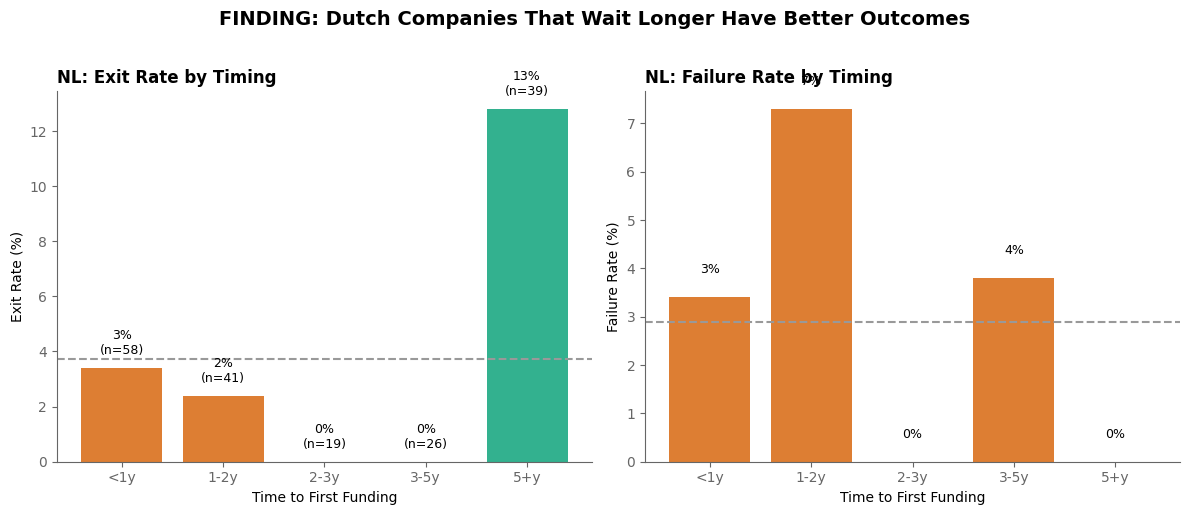

In [13]:
# Visualization: NL timing impact
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Chart 1: Exit rate by timing
ax1 = tufte_style(axes[0])
buckets = nl_timing_outcomes.index.tolist()
exit_rates = nl_timing_outcomes['exit_rate'].values
ns = nl_timing_outcomes['n'].values

colors = [COLORS['success'] if e > nl_timing_outcomes['exit_rate'].mean() else COLORS['failure'] for e in exit_rates]
bars = ax1.bar(buckets, exit_rates, color=colors, alpha=0.8)
for bar, val, n in zip(bars, exit_rates, ns):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{val:.0f}%\n(n={n})', ha='center', fontsize=9)

ax1.set_xlabel('Time to First Funding')
ax1.set_ylabel('Exit Rate (%)')
ax1.set_title('NL: Exit Rate by Timing', fontweight='bold', loc='left')
ax1.axhline(nl_timing_outcomes['exit_rate'].mean(), color=COLORS['gray'], linestyle='--', label='Average')

# Chart 2: Failure rate by timing
ax2 = tufte_style(axes[1])
fail_rates = nl_timing_outcomes['fail_rate'].values
colors2 = [COLORS['failure'] if f > nl_timing_outcomes['fail_rate'].mean() else COLORS['success'] for f in fail_rates]
bars2 = ax2.bar(buckets, fail_rates, color=colors2, alpha=0.8)
for bar, val in zip(bars2, fail_rates):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{val:.0f}%', ha='center', fontsize=9)

ax2.set_xlabel('Time to First Funding')
ax2.set_ylabel('Failure Rate (%)')
ax2.set_title('NL: Failure Rate by Timing', fontweight='bold', loc='left')
ax2.axhline(nl_timing_outcomes['fail_rate'].mean(), color=COLORS['gray'], linestyle='--', label='Average')

plt.suptitle('FINDING: Dutch Companies That Wait Longer Have Better Outcomes', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('figures/deep_dive_1/nl_timing_impact.png', dpi=150, bbox_inches='tight')
plt.show()

---
## Key Findings: Time Between Funding Rounds

| Finding | Evidence | Policy Implication |
|---------|----------|--------------------|
| **Patience pays off** | Companies waiting 3-5+ years before first funding have higher exit rates | Don't push founders to raise early |
| **NL raises faster** | Dutch median time to first funding is lower than benchmark | Counter the "raise fast" culture |
| **Moderate velocity optimal** | 1-2 rounds/year is the sweet spot | Don't celebrate rapid fundraising |
| **Rushing = higher failure** | <1 year to first funding correlates with higher failure rates | Patient capital programs needed |

---